## Overview

### Purpose
The purpose of this project is to develop a predictive model which will help hospitals
reduce their readmission rates among diabetic patients. <br>

### Introduction
A goal of the Affordable Health Care act is to increase the quality of hospital care in U.S hospitals. One specific issue area in which hospitals can improve quality is by improving hospital readmission rates. Under the Affordable Care Act, CMS created the Hospital Readmission Reduction Program in order to link payment data to the quality of hospital care in order to improve health quality for Americans. Essentially, payments to Inpatient Prospective Payment System (IPPS) hospitals depend on each hospital’s readmission rates. Hospitals with poor readmission performance are financially penalized through reduced payments.

#### Hospital Readmission Definitions according to CMS:
The 30-day risk standardized readmission measures include:
- All-cause unplanned readmissions that happen within 30 days of discharge from the index (i.e., initial) admission.
- Patients who are readmitted to the same hospital, or another applicable acute care hospital for any reason.

### Challenge
Develop a model which predicts whether a patient will be readmitted in under 30 days. A diabetic readmission reduction program intervention will use this model in order to target patients at high risk for readmission. Models will be evaluated on __AUC__ and __FPR__.

### Deliverables
Model which predicts <30 readmission

### Data
See data_prep.ipynb in current directory for data preperation efforts. The data cleaning steps has been organized into preprocess.py. 

### Conclusion
If the focus is prediction accuracy (measured by balance of True Positive Rate and False Positive Rate) then we opt Neural Networks.
If the focus is model interpretability
If the focus in both prediction and interpretability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


# from preprocess import clean_data 
# df = clean_data()
# we will directly import processed data from csv file to save loading time.
df = pd.read_csv('./data/df_preprocessed.csv')

In [2]:
print(df.shape)
df.sample(5)

(70443, 46)


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
41412,53897436,Caucasian,Male,[70-80),1,3,7,6,52,1,22,0,0,0,Digestive,Circulatory,Circulatory,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
36718,69789852,Caucasian,Male,[60-70),2,1,1,3,46,2,11,0,0,0,Digestive,Digestive,Digestive,9,None,None,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0
17419,17994564,Caucasian,Female,[80-90),1,1,6,2,53,0,4,0,0,0,Other,Other,Circulatory,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
33416,89227440,Caucasian,Male,[90-100),6,6,7,5,43,0,13,0,0,1,Circulatory,Circulatory,Circulatory,6,Norm,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,1
57456,82648629,Caucasian,Male,[60-70),1,3,7,6,52,1,16,0,0,0,Respiratory,Other,Circulatory,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1


In [3]:
print(f'Missing Data: \n{df.isnull().sum()[df.isnull().sum()>0]} ]\n')
print(f'Dimensions: {df.shape} \n')
print(f'Readmitted Counts: 1 - Readmitted <30 days; 0 - otherwise.\n{df.readmitted.value_counts()}')

Missing Data: 
race      1909
diag_1      13
diag_2     294
diag_3    1198
dtype: int64 ]

Dimensions: (70443, 46) 

Readmitted Counts: 1 - Readmitted <30 days; 0 - otherwise.
0    61609
1     8834
Name: readmitted, dtype: int64


### Generate Feature Columns & Train Test Split

In [4]:
seedn = 1234
X = df.drop('readmitted', axis=1)
y = df['readmitted']

CAT_COLS = X.select_dtypes('object').columns
NUM_COLS = X.select_dtypes('int64').columns

from sklearn.model_selection import train_test_split # 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seedn)

### Baseline Model - Logistic Regression
__Performance Measurement__: TPR, FPR, ROC AUC

In [5]:
def TPR_FPR(mat):
    # TPR = TP/P = TP/(TP + FN)
    # FPR = FP/N = FP/(FP + TN)
    TP = mat[0,0]
    TN = mat[1,1]
    FP = mat[1,0] 
    FN = mat[0,1]
    return (round(TP/(TP+FN),4), round(FP/(FP + TN),4)) # Return tuple of (TPR, FPR)

#### Build Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import cross_val_score
from sklearn import metrics 


DROP_COLS = ['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
def drop_features(X):
    return X.drop(columns=DROP_COLS)

drop_feats = FunctionTransformer(drop_features)

def get_preprocessor(drop=False, bucketize = False, bin_cols = ['num_procedures','num_medications','number_outpatient', 'num_lab_procedures']):

    numeric_cols = NUM_COLS
    dummify_cols = CAT_COLS
    
    
    # simple imputation and dummification for categorical features
    cat_transformer = Pipeline(
        steps=[('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
               ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

    # scaling numeric features
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    transformer_list = [] 
    if drop:
        dummify_cols = [col for col in CAT_COLS if col not in DROP_COLS]

    if bucketize:
        bin_cols = bin_cols
        kbins_transformer = Pipeline(steps = [('discretizer_3bins', KBinsDiscretizer(n_bins = 3, encode='onehot',strategy = 'uniform'))])
        transformer_list.extend([('bins', kbins_transformer, bin_cols)])
        numeric_cols = [col for col in NUM_COLS if col not in bin_cols]
    
    transformer_list.extend([('num', num_transformer, numeric_cols),
                    ('cat', cat_transformer, dummify_cols)])
    
    preprocessor = ColumnTransformer(transformers = transformer_list)

    return preprocessor


def run_model(model, X_train, y_train, X_test, y_test):
    # 3 fold cross validation scores
    accuracy = cross_val_score(model, X_train, y_train, cv=3, scoring = 'balanced_accuracy') 
    aucs = cross_val_score(model, X_train, y_train, cv=3, scoring = 'roc_auc')

    model.fit(X_train, y_train) # fit
    y_pred = model.predict(X_test) # predict
    conf_mat = metrics.confusion_matrix(y_test, y_pred, labels = [1,0])
    tpr, fpr = TPR_FPR(conf_mat)
    auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    # print roc curve
    disp = metrics.plot_roc_curve(model, X_test, y_test)
    disp.ax_.set_title('ROC curve')
    print(f'Cross validated Balanced Accuracy = {np.round(np.mean(accuracy),4)} (+/- {np.round(np.std(accuracy),4)}) \n' \
          f'Cross validated AUC-ROC = {np.round(np.mean(aucs),4)} (+/- {np.round(np.std(aucs),4)}) \n' \
          f'Test Set Scores: \n True Positive Rate = {tpr}  False Positive Rate = {fpr}  AUC = {np.round(auc,4)}')
    print(f'Confusion Matrix: \n {conf_mat}')

### Drop vs Not Dropping Categorical Features

Cross validated Balanced Accuracy = 0.5399 (+/- 0.0015) 
Cross validated AUC-ROC = 0.7137 (+/- 0.0086) 
Test Set Scores: 
 True Positive Rate = 0.0749  False Positive Rate = 0.0073  AUC = 0.7107
Confusion Matrix: 
 [[  136  1680]
 [   89 12184]]
CPU times: user 1min 49s, sys: 7.46 s, total: 1min 57s
Wall time: 31.6 s


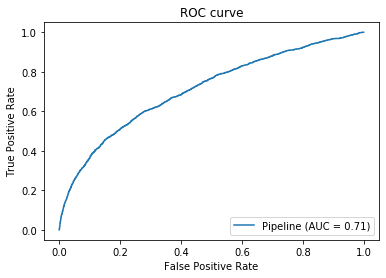

In [7]:
from sklearn.linear_model import LogisticRegression
logit = Pipeline(steps=[('preprocessor', get_preprocessor()),
                        ('classifier', LogisticRegression(max_iter=1000))])
%time run_model(logit, X_train, y_train, X_test, y_test)

Cross validated Balanced Accuracy = 0.5399 (+/- 0.0015) 
Cross validated AUC-ROC = 0.7138 (+/- 0.0086) 
Test Set Scores: 
 True Positive Rate = 0.0749  False Positive Rate = 0.0073  AUC = 0.7108
Confusion Matrix: 
 [[  136  1680]
 [   89 12184]]
CPU times: user 41 s, sys: 2.28 s, total: 43.3 s
Wall time: 24.1 s


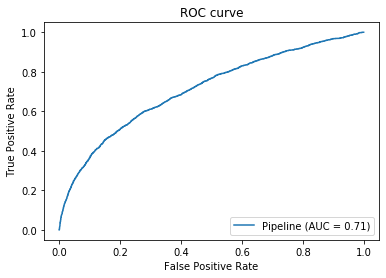

In [8]:
logit2 = Pipeline(steps=[('drop_feats', drop_feats),
                        ('preprocessor', get_preprocessor(drop=True)),
                        ('classifier', LogisticRegression(max_iter=1000))])
%time run_model(logit2, X_train, y_train, X_test, y_test)

- From above, it's clear that these 9 categorical columns provided almost no information in predicting the readmission. We make the decision to drop these columns in our models.

- __Also notice that TPR is extremly low due to the unbalanced training dataset. Let's use Upsampling to balance out our training set.__

### Upsampling

As you will see below, upsampling gives us __significantly improved__ True Positive Rate at the cost of higher False Positive Rate. Overall AUC ROC did not change much.

In [9]:
np.random.seed(seedn) 
msk = np.random.rand(df.shape[0]) < 0.8
train = df[msk]
test = df[~msk]
print(f'Train:\n{train.readmitted.value_counts()}\nTest:\n{test.readmitted.value_counts()}')

yes = train[train['readmitted']==1]
no = train[train['readmitted']==0]
n = no.shape[0]
no = no.sample(n=n, replace = True, random_state = seedn)
yes = yes.sample(n=n, replace = True, random_state = seedn)
train_up = pd.concat([yes,no], axis = 0)
print(f'Train upsampled readmitted value counts: \n{train_up.readmitted.value_counts()}')

X_train_up = train_up.drop('readmitted', axis = 1)
y_train_up = train_up['readmitted']
X_test = test.drop('readmitted', axis = 1)
y_test = test['readmitted']

print(f'New Upsampled X_train, y_train, X_test, y_test: {X_train_up.shape}, {y_train_up.shape}, {X_test.shape}, {y_test.shape}')

Train:
0    49290
1     6998
Name: readmitted, dtype: int64
Test:
0    12319
1     1836
Name: readmitted, dtype: int64
Train upsampled readmitted value counts: 
1    49290
0    49290
Name: readmitted, dtype: int64
New Upsampled X_train, y_train, X_test, y_test: (98580, 45), (98580,), (14155, 45), (14155,)


### Logistic Regression after Upsampling

Cross validated Balanced Accuracy = 0.6626 (+/- 0.0014) 
Cross validated AUC-ROC = 0.7235 (+/- 0.002) 
Test Set Scores: 
 True Positive Rate = 0.5605  False Positive Rate = 0.2399  AUC = 0.7142
Confusion Matrix: 
 [[1029  807]
 [2955 9364]]
CPU times: user 5.97 s, sys: 1.07 s, total: 7.04 s
Wall time: 51.4 s


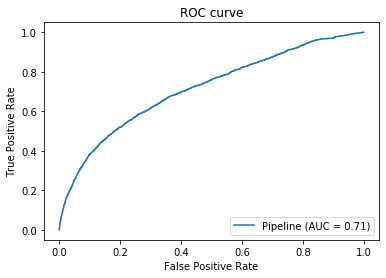

In [10]:
logit = Pipeline(steps=[('drop_feats', drop_feats), # dropping 9 redundant features, reducing feature size to 37 before dummification
                        ('preprocessor', get_preprocessor(drop = True)),
                        ('classifier', LogisticRegression(max_iter=1000, n_jobs = -1))])
%time run_model(logit, X_train_up, y_train_up, X_test, y_test) # using upsampled training data

### + Bucketize

- bucketizing improves generalization of our model as showned below. We have slightly higher TPR and FPR with bucketization.

Cross validated Balanced Accuracy = 0.6625 (+/- 0.0008) 
Cross validated AUC-ROC = 0.7236 (+/- 0.0017) 
Test Set Scores: 
 True Positive Rate = 0.5664  False Positive Rate = 0.2382  AUC = 0.7158
Confusion Matrix: 
 [[1040  796]
 [2934 9385]]
CPU times: user 6.21 s, sys: 1.06 s, total: 7.27 s
Wall time: 47.4 s


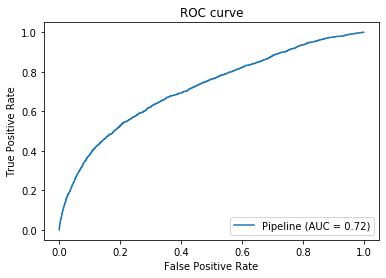

In [11]:
logit2 = Pipeline(steps=[('drop_feats', drop_feats),
                         ('preprocessor', get_preprocessor(drop = True, bucketize = True)),
                        ('classifier', LogisticRegression(max_iter = 1000, n_jobs = -1))])
%time run_model(logit2, X_train_up, y_train_up, X_test, y_test)

### hyper parameters: C

Best Params based on True Positive Rate: 
    classifier__C  mean_test_AUC  mean_train_AUC  mean_test_Accuracy  \
4          100.0       0.723999        0.726322            0.662624   

   mean_train_Accuracy  
4             0.663903  
Best Params based on ROC AUC: 
    classifier__C  mean_test_AUC  mean_train_AUC  mean_test_Accuracy  \
2            1.0       0.724046         0.72634            0.662391   

   mean_train_Accuracy  
2             0.663807   


[None]

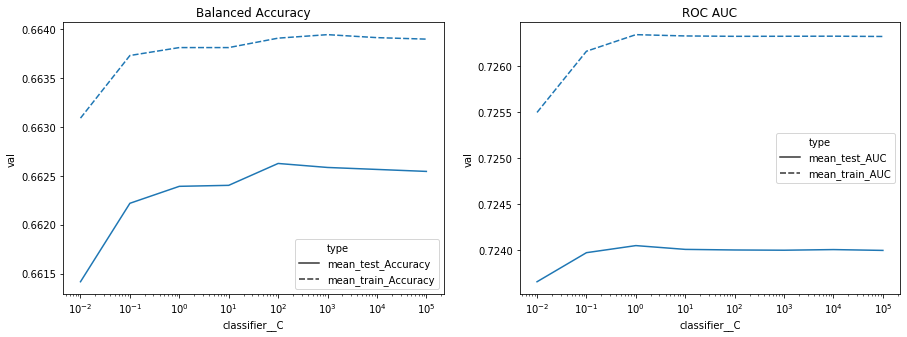

In [12]:
from sklearn.model_selection import KFold, GridSearchCV

Cs = [0.01,0.1,1,10,100,1e3,1e4,1e5] # L2 regularization strength
param_grid = {
    'classifier__C': Cs
}
cv = KFold(3, shuffle=True, random_state=seedn)
gs = GridSearchCV(logit2, param_grid, n_jobs=1, scoring = {'AUC':'roc_auc','Accuracy':'balanced_accuracy'}, cv = cv, 
                       return_train_score = True, refit = False)
gs.fit(X_train_up, y_train_up) # fit

gs_results = gs.cv_results_
results = pd.DataFrame(gs_results['params']) # generate dataframe to analyze grid search results
for score in ['mean_test_AUC','mean_train_AUC', 'mean_test_Accuracy','mean_train_Accuracy']:
    results[score] = gs_results[score]
best_param_TPR = results[results['mean_test_Accuracy']==max(results['mean_test_Accuracy'])]
best_param_AUC = results[results['mean_test_AUC']==max(results['mean_test_AUC'])]

print(f'Best Params based on True Positive Rate: \n {best_param_TPR}')
print(f'Best Params based on ROC AUC: \n {best_param_AUC} ')

# visualize scores
fig, axes = plt.subplots(1,2, figsize = (15, 5))
tmp1 = results.melt(id_vars = ['classifier__C'],value_vars=['mean_test_Accuracy','mean_train_Accuracy'], var_name='type', value_name='val')
tmp2 = results.melt(id_vars = ['classifier__C'],value_vars=['mean_test_AUC','mean_train_AUC'], var_name='type', value_name='val')

sns.lineplot(x='classifier__C', y='val', style = 'type', data=tmp1, ax = axes[0])
sns.lineplot(x='classifier__C', y='val', style = 'type', data=tmp2, ax = axes[1])# print("Best parameter (CV ROC AaUC Score =%0.3f):" % search.best_score_)

axes[0].set_title('Balanced Accuracy')
axes[0].set(xscale="log")
axes[1].set_title('ROC AUC')
axes[1].set(xscale="log")

*As shown above, different scoring strategy results in different best parameters for our model.
For our problem, we prioritize both True Positive Rate(we accurately predict readmission) and False Positive Rate (incorrectly predict patient to be readmitted when in face the patient is not readmitted). We need to strike a balance between the two.*
- the sklearn defaul C=1 is the best model with highest AUC from cross validation
- C=100 is the grid search result for best True Positive Rate.
The different is very small, almost neglegible, as also shown in the test set results below.
- There is a little bit of over fitting as training scores are better than the test scores.

We could do more here, but let's move on to other models to see if any of the out of the box models perform better than simple logistic regression. The benefit of using logistic regression is that it is simple and straight forward and also the run speed is fast. However, if the ultimate prediction accuracy is our goal, we can explore other models in hopes to achieve higher accuracy at the cost of the complexity.

## Random Forest Classifier

*Run Default Random Forest Model*

Cross validated Balanced Accuracy = 0.9841 (+/- 0.001) 
Cross validated AUC-ROC = 0.9985 (+/- 0.0002) 
Test Set Scores: 
 True Positive Rate = 0.1939  False Positive Rate = 0.0291  AUC = 0.7182
Confusion Matrix: 
 [[  356  1480]
 [  359 11960]]
CPU times: user 51.1 s, sys: 4.81 s, total: 55.9 s
Wall time: 36.6 s


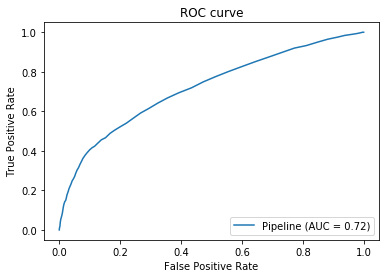

In [15]:
# basic sklearn default RFC
#100 trees, 'gini', no max_dept, split at 2 samples, max_features at each split is sqrt(no. of features = 45 or 37 for reduced feature space.) ~ 6

from sklearn.ensemble import RandomForestClassifier

rfc = Pipeline(steps=[('preprocessor', get_preprocessor()),
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = -1))]) 
%time run_model(rfc,X_train_up, y_train_up, X_test, y_test) # upsampled training data

*Run default model again with 37 reduced features plus bucketized columns*

Cross validated Balanced Accuracy = 0.9829 (+/- 0.0009) 
Cross validated AUC-ROC = 0.9985 (+/- 0.0002) 
Test Set Scores: 
 True Positive Rate = 0.2048  False Positive Rate = 0.0346  AUC = 0.7143
Confusion Matrix: 
 [[  376  1460]
 [  426 11893]]
CPU times: user 6min 25s, sys: 6.4 s, total: 6min 31s
Wall time: 4min 3s


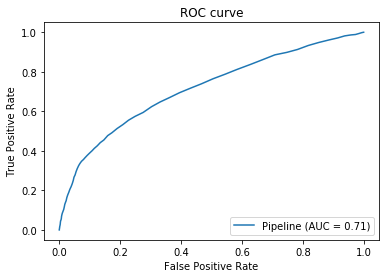

In [16]:
# + Drop 9 feat and Bucketize
rfc2 = Pipeline(steps=[('drop_feats', drop_feats),
                      ('preprocessor', get_preprocessor(drop = True, bucketize = True)), #  dropping redundant features, dummify and scale
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = -1))]) 
%time run_model(rfc2, X_train_up, y_train_up, X_test, y_test)

- Sklearn off the shelf random forest model is already performing better than logistic regression judging from the ROC AUC. (rfc: 0.7182 vs logit: 0.7151)
- in Random Forest Model, unlike logistic regression model, we don't see a benefit in dropping and bucketizing our features.
- we will use the original feature space when searching for the best parameters for Random Forest Model below.

## Hyper Parameter Tuning - RFC
### Sklearn Default Random Forest parameters

In [20]:
rfc.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['patient_nbr', 'admission_type_id', 'discharge_disposition_id',
       'admission_sou...
      

### Overfitting Issue

As you can see the model is severly overfit. Let's tune the hypter parameters to control the overfitting and improve generalization.

*Hyper parameter tuning for Random Forest Classifier*
- N_estimators (no. of trees): The more the tree, the longer it takes to train but will improve generalization as a forest with 100 trees will be more stable than a forest with 10 trees. However, this is to the proportion of the dataset size, because if we are building 1000 tree when the dataset size is only 1000 observations, we are at risk of overfitting.
- Max Depth: The deeper the tree, the more complex the model becomes and is at risk of overfitting.If None (which is the Sklearn default), then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_sample_split: Controls the depth of tree when Max Depth is big or None. 
- min_samples_leaf: Min number of samples required to be a leaf node. similar to min_sample_split, this controls overfitting by limitting the behavior of a tree creating a bunch of small branches exclusively for one sample each. 
- min_weight_fraction_leaf: the fraction of the input samples required to be at a leaf node where weights are determined by sample_weight, this is a way to deal with class imbalance. 
- max_features: sklearn default is 'auto' which is the sqrt of feature size, in our case if 37 for reduced features 45 for original features. So current default max_feature using our dtaset is around 6.


There are more parameters but we will focus on the above for our project.

### Randomized Search CV

In [21]:
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV

n_estimators = [x for x in range(100, 300,50)] # Number of trees in random forest
max_features = ['auto', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] # Number of features to consider at every split
max_depth = [x for x in range(3,31,3)] # Maximum number of levels in tree
# min_samples_split = [4, 8, 12, 16] # # Minimum number of samples required to split a node
min_weight_fraction_leaf = np.linspace(0.1,0.5,5) # the fraction of the input samples required to be at a leaf node where weights are determined by sample_weight, which helps with class imbalance
min_samples_leaf = [3, 6, 9, 12, 15] # # Minimum number of samples required at each leaf node

# bootstrap = [True, False] # Method of selecting samples for training each tree
# oob_score = [True, False] # whether to use out of bag samples to estimate the accuracy
# min_impurity_decrease = [0,1e5] # early stopping to help better generalization. A node will split if its impurity is above the threshold, otherwise it is a leaf.

# Create the random grid
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_weight_fraction_leaf': min_weight_fraction_leaf,
#                'classifier__bootstrap': bootstrap,
#                'classifier__oob_score':oob_score,
#                'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf
              }
print(random_grid)

cv = KFold(3, shuffle=True, random_state=seedn)
rsearch = RandomizedSearchCV(rfc, random_grid, n_iter = 40, n_jobs=1, 
                             scoring = {'AUC':'roc_auc', 'Accuracy':'balanced_accuracy'}, cv = cv, 
                             random_state= seedn, refit=False, return_train_score = True)
rsearch.fit(X_train_up, y_train_up)

results = rsearch.cv_results_
rsearch_results = pd.DataFrame(results['params'])
for score in ['mean_test_AUC','mean_train_AUC','mean_test_Accuracy','mean_train_Accuracy']:
    rsearch_results[score] = results[score]
    
best_param_TPR = rsearch_results[rsearch_results['mean_test_Accuracy']==max(rsearch_results['mean_test_Accuracy'])]
best_param_AUC = rsearch_results[rsearch_results['mean_test_AUC']==max(rsearch_results['mean_test_AUC'])]

print('Best Params based on Balanced Accuracy: ')
display(best_param_TPR)
print('Best Params based on ROC AUC:') 
display(best_param_AUC)

{'classifier__n_estimators': [100, 150, 200, 250], 'classifier__max_features': ['auto', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 'classifier__max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30], 'classifier__min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'classifier__min_samples_leaf': [3, 6, 9, 12, 15]}
Best Params based on Balanced Accuracy: 


,classifier__n_estimators,classifier__min_weight_fraction_leaf,classifier__min_samples_leaf,classifier__max_features,classifier__max_depth,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
32,250,0.1,3,0.5,21,0.721208,0.72196,0.663475,0.663437


Best Params based on ROC AUC:


,classifier__n_estimators,classifier__min_weight_fraction_leaf,classifier__min_samples_leaf,classifier__max_features,classifier__max_depth,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
28,150,0.1,9,0.7,15,0.721816,0.722708,0.661246,0.662476


As shown above, different scoring strategy results in different best parameters for our model.
For our problem, we prioritize both True Positive Rate(we accurately predict readmission) and False Positive Rate (incorrectly predict patient to be readmitted when in face the patient is not readmitted). We need to strike a balance between the two.

2 good models from Random Search:

- First Model: 
    - {'classifier__n_estimators': 250, 
    - 'classifier__min_weight_fraction_leaf': 0.1, 
    - 'classifier__min_samples_leaf': 3, 
    - 'classifier__max_features': 0.5, 
    - 'classifier__max_depth': 21}
        - Random Search Best ROC AUC Score: 0.721208
        - Random Search Best Accuracy Score: 0.663475

- Second Model: 
    - {'classifier__n_estimators': 150, 
    - 'classifier__min_weight_fraction_leaf': 0.1, 
    - 'classifier__min_samples_leaf': 9, 
    - 'classifier__max_features': 0.7, 
    - 'classifier__max_depth': 15}
        - Random Search Best ROC AUC Score: 0.721816
        - Random Search Best Accuracy Score: 0.662476
<br><br>
- Let's reinitialize RFC with these parameters check our performance.

Cross validated Balanced Accuracy = 0.6626 (+/- 0.0014) 
Cross validated AUC-ROC = 0.7213 (+/- 0.0027) 
Test Set Scores: 
 True Positive Rate = 0.6051  False Positive Rate = 0.2886  AUC = 0.7125
Confusion Matrix: 
 [[1111  725]
 [3555 8764]]
CPU times: user 4min 16s, sys: 2.43 s, total: 4min 18s
Wall time: 4min 19s


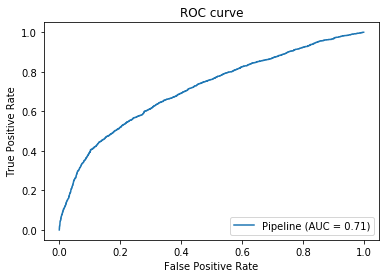

In [22]:
rfc3 = Pipeline(steps=[('preprocessor', get_preprocessor()), #  dropping redundant features, dummify and scale
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = 1,n_estimators = 250, 
                                                            min_weight_fraction_leaf = 0.1, min_samples_leaf = 3,
                                                            max_features = 0.5, max_depth = 21
                                                           ))])
%time run_model(rfc3, X_train_up, y_train_up, X_test, y_test)

Cross validated Balanced Accuracy = 0.6606 (+/- 0.0026) 
Cross validated AUC-ROC = 0.7216 (+/- 0.0031) 
Test Set Scores: 
 True Positive Rate = 0.5594  False Positive Rate = 0.2418  AUC = 0.7136
Confusion Matrix: 
 [[1027  809]
 [2979 9340]]
CPU times: user 3min 31s, sys: 2.01 s, total: 3min 33s
Wall time: 3min 34s


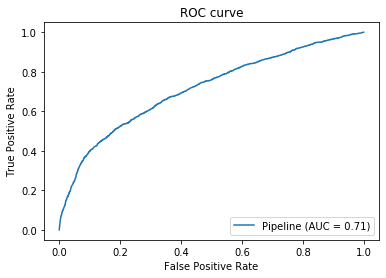

In [23]:
rfc4 = Pipeline(steps=[('preprocessor', get_preprocessor()), #  dropping redundant features, dummify and scale
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = 1,n_estimators = 150, 
                                                            min_weight_fraction_leaf = 0.1, min_samples_leaf = 9,
                                                            max_features = 0.7, max_depth = 15
                                                           ))])
%time run_model(rfc4, X_train_up, y_train_up, X_test, y_test)

## GridSearchCV
Another method of searching for the best parameter is gridsearch. It is more computationally expensive as it searches for all possible combinations of the param grid. The benefit is that it's more thorough search than Randomized search as we won't miss out on any good parameters.

### tuning max_depth and number of trees

Best Params based on True Positive Rate: 
     classifier__max_depth  classifier__n_estimators  mean_test_AUC  \
34                     21                      1000       0.994615   

    mean_train_AUC  mean_test_TPR  mean_train_TPR  
34         0.99987       0.983566        0.994938  
Best Params based on ROC AUC: 
     classifier__max_depth  classifier__n_estimators  mean_test_AUC  \
34                     21                      1000       0.994615   

    mean_train_AUC  mean_test_TPR  mean_train_TPR  
34         0.99987       0.983566        0.994938   


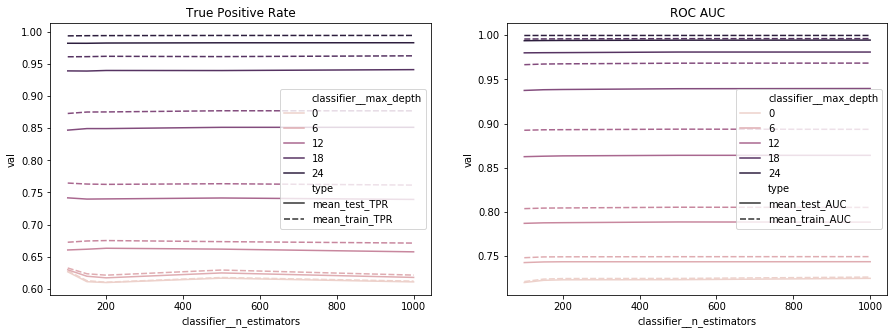

In [110]:
from sklearn.model_selection import KFold, GridSearchCV

max_depth_range = [3, 5, 7, 9, 11, 15]
num_trees = [100, 150, 200, 500, 1000]

# define parameters to search
param_grid = {
    'classifier__max_depth': max_depth_range,
    'classifier__n_estimators': num_trees

}
cv = KFold(3, shuffle=True, random_state=seedn)
gsearch = GridSearchCV(rfc, param_grid, n_jobs=1, scoring = {'AUC':'roc_auc', 'Accuracy':'balanced_accuracy'}, cv = cv, 
                       return_train_score = True, refit = False)
gsearch.fit(X_train_up, y_train_up) # fit

cv_results = gsearch.cv_results_
gsearch_results = pd.DataFrame(cv_results['params']) # generate dataframe to analyze grid search results
for score in ['mean_test_AUC','mean_train_AUC','mean_test_Accuracy','mean_train_Accuracy']:
    gsearch_results[score] = cv_results[score]
best_param_Accuracy = gsearch_results[gsearch_results['mean_test_Accuracy']==max(gsearch_results['mean_test_Accuracy'])]
best_param_AUC = gsearch_results[gsearch_results['mean_test_AUC']==max(gsearch_results['mean_test_AUC'])]

print('Best Params based on Accuracy:')
display(best_param_Accuracy)
print('Best Params based on ROC AUC:')
display(best_param_AUC)

# visualize scores
tmp1 = gsearch_results.melt(id_vars = ['classifier__max_depth','classifier__n_estimators'],value_vars=['mean_test_Accuracy','mean_train_Accuracy'], var_name='type', value_name='val')
tmp2 = gsearch_results.melt(id_vars = ['classifier__max_depth','classifier__n_estimators'],value_vars=['mean_test_AUC','mean_train_AUC'], var_name='type', value_name='val')

fig, axes = plt.subplots(2,2, figsize=(15,5))
axes[0].set_title('Balanced Accuracy')
axes[1].set_title('ROC AUC')
sns.lineplot(x='classifier__n_estimators', y='val', hue='classifier__max_depth', style = 'type', data=tmp1, ax = axes[0])
sns.lineplot(x='classifier__n_estimators', y='val', hue='classifier__max_depth', style = 'type', data=tmp2, ax = axes[1])# print("Best parameter (CV ROC AaUC Score =%0.3f):" % search.best_score_)

- Observation: The number of estimator doesn't drastically improve the scores. 

Since it takes longer to run grid search on larger number of trees, we will continue searching for best parameters using 100 sklearn default tree size.

### tuning max depth and min samples leaf

Best Params based on Accuracy:


,classifier__max_depth,classifier__min_samples_leaf,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
30,21,3,0.975329,0.995622,0.922865,0.96646


Best Params based on ROC AUC:


,classifier__max_depth,classifier__min_samples_leaf,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
30,21,3,0.975329,0.995622,0.922865,0.96646


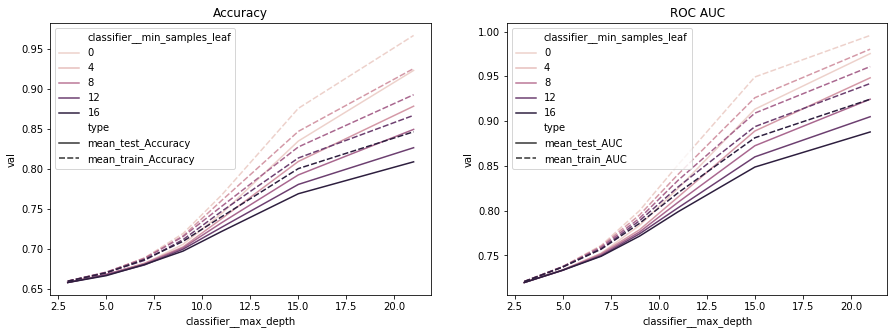

In [25]:
max_depth_range = [3, 5, 7, 9, 11, 15, 21]
min_samples_leaf = [3, 6, 9, 12, 15] 

param_grid = {
    'classifier__max_depth': max_depth_range,
    'classifier__min_samples_leaf': min_samples_leaf

}
cv = KFold(3, shuffle=True, random_state=seedn)
gsearch = GridSearchCV(rfc, param_grid, n_jobs=1, scoring = {'AUC':'roc_auc', 'Accuracy':'balanced_accuracy'}, cv = cv, 
                       return_train_score = True, refit = False)
gsearch.fit(X_train_up, y_train_up)

cv_results = gsearch.cv_results_
gsearch_results = pd.DataFrame(cv_results['params'])
for score in ['mean_test_AUC','mean_train_AUC','mean_test_Accuracy','mean_train_Accuracy']:
    gsearch_results[score] = cv_results[score]
best_param_Accuracy = gsearch_results[gsearch_results['mean_test_Accuracy']==max(gsearch_results['mean_test_Accuracy'])]
best_param_AUC = gsearch_results[gsearch_results['mean_test_AUC']==max(gsearch_results['mean_test_AUC'])]

print('Best Params based on Accuracy:')
display(best_param_Accuracy)
print('Best Params based on ROC AUC:')
display(best_param_AUC)
      
tmp1 = gsearch_results.melt(id_vars = ['classifier__max_depth','classifier__min_samples_leaf'],value_vars=['mean_test_Accuracy','mean_train_Accuracy'], var_name='type', value_name='val')
tmp2 = gsearch_results.melt(id_vars = ['classifier__max_depth','classifier__min_samples_leaf'],value_vars=['mean_test_AUC','mean_train_AUC'], var_name='type', value_name='val')

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].set_title('Accuracy')
axes[1].set_title('ROC AUC')
sns.lineplot(x='classifier__max_depth', y='val', hue='classifier__min_samples_leaf', style = 'type', data=tmp1, ax = axes[0])
sns.lineplot(x='classifier__max_depth', y='val', hue='classifier__min_samples_leaf', style = 'type', data=tmp2, ax = axes[1])# print("Best parameter (CV ROC AaUC Score =%0.3f):" % search.best_score_)

___Best model with 'Accuracy' as scoring strategy.___

Cross validated Balanced Accuracy = 0.9255 (+/- 0.0004) 
Cross validated AUC-ROC = 0.9763 (+/- 0.0001) 
Test Set Scores: 
 True Positive Rate = 0.3911  False Positive Rate = 0.0917  AUC = 0.725
Confusion Matrix: 
 [[  718  1118]
 [ 1130 11189]]
CPU times: user 1min 48s, sys: 1.82 s, total: 1min 50s
Wall time: 1min 50s


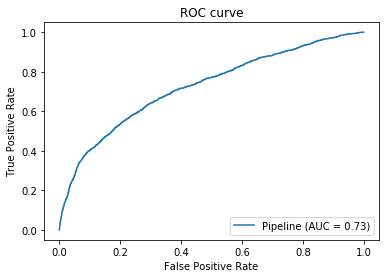

In [28]:
rfc5 = Pipeline(steps=[('preprocessor', get_preprocessor()),
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = 1,n_estimators = 150, 
                                                            min_samples_leaf = 3, max_depth = 21
                                                           ))])
%time run_model(rfc5, X_train_up, y_train_up, X_test, y_test)

___Best model with 'AUC' as scoring strategy.___

Cross validated Balanced Accuracy = 0.7687 (+/- 0.0018) 
Cross validated AUC-ROC = 0.8498 (+/- 0.0016) 
Test Set Scores: 
 True Positive Rate = 0.5229  False Positive Rate = 0.1939  AUC = 0.7251
Confusion Matrix: 
 [[ 960  876]
 [2389 9930]]
CPU times: user 1min 36s, sys: 1.73 s, total: 1min 37s
Wall time: 1min 38s


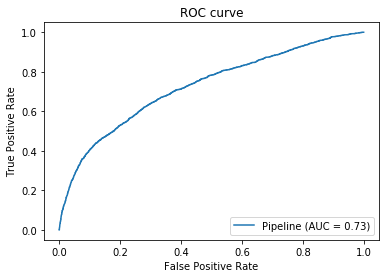

In [31]:
rfc5 = Pipeline(steps=[('preprocessor', get_preprocessor()), 
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = 1,n_estimators = 150, 
                                                            min_samples_leaf = 15, max_depth = 15
                                                           ))])
%time run_model(rfc5, X_train_up, y_train_up, X_test, y_test)

### Tuning max features and min_weight_fraction_leaf

Best Params based on Accuracy:


,classifier__max_features,classifier__min_weight_fraction_leaf,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
54,0.8,0.0,0.912178,0.94859,0.834087,0.875858


Best Params based on ROC AUC:


,classifier__max_features,classifier__min_weight_fraction_leaf,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
54,0.8,0.0,0.912178,0.94859,0.834087,0.875858


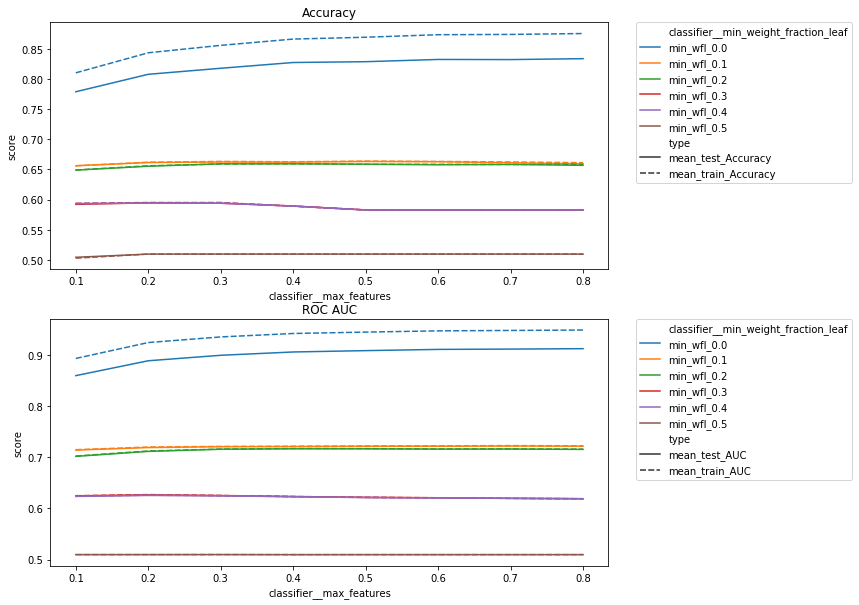

In [86]:
max_features = ['auto', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] # Number of features to consider at every split
min_weight_fraction_leaf = [0, 0.1, 0.2, 0.3, 0.4, 0.5]# the fraction of the input samples required to be at a leaf node where weights are determined by sample_weight, which helps with class imbalance

param_grid = {
    'classifier__max_features': max_features,
    'classifier__min_weight_fraction_leaf': min_weight_fraction_leaf,

}
cv = KFold(3, shuffle=True, random_state=seedn)
gsearch = GridSearchCV(rfc5, param_grid, n_jobs=1, scoring = {'AUC':'roc_auc', 'Accuracy':'balanced_accuracy'}, cv = cv, 
                       return_train_score = True, refit = False)
gsearch.fit(X_train_up, y_train_up)

cv_results = gsearch.cv_results_
gsearch_results = pd.DataFrame(cv_results['params'])
for score in ['mean_test_AUC','mean_train_AUC','mean_test_Accuracy','mean_train_Accuracy']:
    gsearch_results[score] = cv_results[score]
best_param_Accuracy = gsearch_results[gsearch_results['mean_test_Accuracy']==max(gsearch_results['mean_test_Accuracy'])]
best_param_AUC = gsearch_results[gsearch_results['mean_test_AUC']==max(gsearch_results['mean_test_AUC'])]

print('Best Params based on Accuracy:')
display(best_param_Accuracy)
print('Best Params based on ROC AUC:')
display(best_param_AUC)
      
tmp1 = gsearch_results.melt(id_vars = ['classifier__max_features','classifier__min_weight_fraction_leaf'],value_vars=['mean_test_Accuracy','mean_train_Accuracy'], var_name='type', value_name='val')
tmp1.classifier__min_weight_fraction_leaf = tmp1.classifier__min_weight_fraction_leaf.apply(lambda x: 'min_wfl_'+str(x))

tmp2 = gsearch_results.melt(id_vars = ['classifier__max_features','classifier__min_weight_fraction_leaf'],value_vars=['mean_test_AUC','mean_train_AUC'], var_name='type', value_name='val')
tmp2.classifier__min_weight_fraction_leaf = tmp2.classifier__min_weight_fraction_leaf.apply(lambda x: 'min_wfl_'+str(x))
fig, axes = plt.subplots(2,1, figsize = (10,10))


sns.lineplot(x='classifier__max_features', y='val', hue='classifier__min_weight_fraction_leaf', style = 'type', data=tmp1[~tmp1.classifier__max_features.isin(['auto','log2'])], ax = axes[0])
axes[0].set_title('Accuracy')
axes[0].set(ylabel='score')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.lineplot(x='classifier__max_features', y='val', hue='classifier__min_weight_fraction_leaf', style = 'type', data=tmp2[~tmp2.classifier__max_features.isin(['auto','log2'])], ax = axes[1])# print("Best parameter (CV ROC AaUC Score =%0.3f):" % search.best_score_)
axes[1].set_title('ROC AUC')
axes[1].set(ylabel='score')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Note: __Seaborn Known Issue: Incorrect legend in lineplot when using numeric values in hue:__ https://github.com/mwaskom/seaborn/issues/1653

Workaround: concat a string + number and supply to hue as shown above

__observation__
- although grid search picked max features 0.8 and Min wfl 0, we can see from the above graph that it is not a good choice because model is overfit to the training data (training accuracy and auc is significantly higher at 0.8 and 0.0.
- we will choose max_feature 0.3 and min wfl 0.1 

Cross validated Balanced Accuracy = 0.6622 (+/- 0.0026) 
Cross validated AUC-ROC = 0.7206 (+/- 0.0024) 
Test Set Scores: 
 True Positive Rate = 0.6024  False Positive Rate = 0.2891  AUC = 0.7117
Confusion Matrix: 
 [[1106  730]
 [3562 8757]]
CPU times: user 1min 43s, sys: 1.79 s, total: 1min 45s
Wall time: 1min 46s


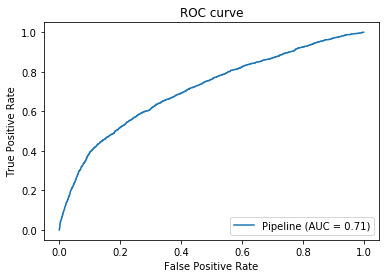

In [87]:
# final grid search rfc model
final_gs_rfc = Pipeline(steps=[('preprocessor', get_preprocessor()), 
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = 1,n_estimators = 150, 
                                                            min_samples_leaf = 15, max_depth = 15,
                                                            max_features = 0.3, min_weight_fraction_leaf = 0.1
                                                           ))])
%time run_model(final_gs_rfc, X_train_up, y_train_up, X_test, y_test)

Cross validated Balanced Accuracy = 0.6626 (+/- 0.0016) 
Cross validated AUC-ROC = 0.7208 (+/- 0.0025) 
Test Set Scores: 
 True Positive Rate = 0.6138  False Positive Rate = 0.3016  AUC = 0.7118
Confusion Matrix: 
 [[1127  709]
 [3716 8603]]
CPU times: user 5min 32s, sys: 2.85 s, total: 5min 35s
Wall time: 5min 37s


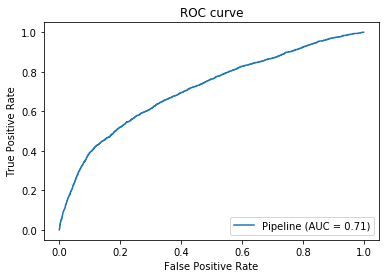

In [88]:
# increase no of trees to 500
rfc6 = Pipeline(steps=[('preprocessor', get_preprocessor()),
                      ('classifier', RandomForestClassifier(random_state=seedn, n_jobs = 1,n_estimators = 500, 
                                                            min_samples_leaf = 15, max_depth = 15,
                                                            max_features = 0.3, min_weight_fraction_leaf = 0.1
                                                           ))])
%time run_model(rfc6, X_train_up, y_train_up, X_test, y_test)

## Gradient Boosting Classifier

Cross validated Balanced Accuracy = 0.6822 (+/- 0.0012) 
Cross validated AUC-ROC = 0.7512 (+/- 0.0017) 
Test Set Scores: 
 True Positive Rate = 0.5583  False Positive Rate = 0.2147  AUC = 0.73
Confusion Matrix: 
 [[1025  811]
 [2645 9674]]


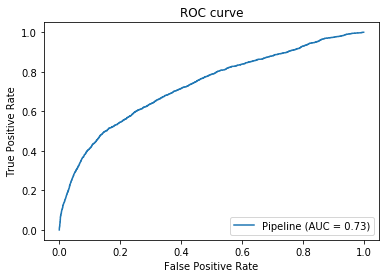

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = Pipeline(steps=[('preprocessor', get_preprocessor(drop=True, bucketize = True)),
                      ('classifier', GradientBoostingClassifier(random_state=seedn))])
run_model(gbc,X_train_up, y_train_up, X_test, y_test)

In [10]:
gbc.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('bins',
                                                  Pipeline(memory=None,
                                                           steps=[('discretizer_3bins',
                                                                   KBinsDiscretizer(encode='onehot',
                                                                                    n_bins=3,
                                                                                    strategy='uniform'))],
                                                           verbose=False),
                                                  ['num_procedures',
                                                   'num_medi

In [11]:
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV

n_estimators = [x for x in range(100, 300,50)] # Number of trees in random forest
max_features = ['auto', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] # Number of features to consider at every split
max_depth = [x for x in range(3,31,3)] # Maximum number of levels in tree
# min_samples_split = [4, 8, 12, 16] # # Minimum number of samples required to split a node
min_weight_fraction_leaf = np.linspace(0.1,0.5,5) # the fraction of the input samples required to be at a leaf node where weights are determined by sample_weight, which helps with class imbalance
min_samples_leaf = [3, 6, 9, 12, 15] # # Minimum number of samples required at each leaf node
n_iter_no_change = [0, 10, 20, 30, 40, 50, 75, 100]

# Create the random grid
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_weight_fraction_leaf': min_weight_fraction_leaf,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__n_iter_no_change': n_iter_no_change
              }
print(random_grid)

cv = KFold(3, shuffle=True, random_state=seedn)
rsearch = RandomizedSearchCV(gbc, random_grid, n_iter = 10, n_jobs=1, 
                             scoring = {'AUC':'roc_auc', 'Accuracy':'balanced_accuracy'}, cv = cv, 
                             random_state= seedn, refit=False, return_train_score = True)
rsearch.fit(X_train_up, y_train_up)

results = rsearch.cv_results_
rsearch_results = pd.DataFrame(results['params'])
for score in ['mean_test_AUC','mean_train_AUC','mean_test_Accuracy','mean_train_Accuracy']:
    rsearch_results[score] = results[score]
    
best_param_TPR = rsearch_results[rsearch_results['mean_test_Accuracy']==max(rsearch_results['mean_test_Accuracy'])]
best_param_AUC = rsearch_results[rsearch_results['mean_test_AUC']==max(rsearch_results['mean_test_AUC'])]

print('Best Params based on Balanced Accuracy: ')
display(best_param_TPR)
print('Best Params based on ROC AUC:') 
display(best_param_AUC)

{'classifier__n_estimators': [100, 150, 200, 250], 'classifier__max_features': ['auto', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 'classifier__max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30], 'classifier__min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'classifier__min_samples_leaf': [3, 6, 9, 12, 15], 'classifier__n_iter_no_change': [0, 10, 20, 30, 40, 50, 75, 100]}
Best Params based on Balanced Accuracy: 


,classifier__n_iter_no_change,classifier__n_estimators,classifier__min_weight_fraction_leaf,classifier__min_samples_leaf,classifier__max_features,classifier__max_depth,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
7,20,250,0.1,12,0.8,9,0.746193,0.751313,0.678388,0.681893


Best Params based on ROC AUC:


,classifier__n_iter_no_change,classifier__n_estimators,classifier__min_weight_fraction_leaf,classifier__min_samples_leaf,classifier__max_features,classifier__max_depth,mean_test_AUC,mean_train_AUC,mean_test_Accuracy,mean_train_Accuracy
7,20,250,0.1,12,0.8,9,0.746193,0.751313,0.678388,0.681893


Cross validated Balanced Accuracy = 0.6779 (+/- 0.002) 
Cross validated AUC-ROC = 0.7455 (+/- 0.0017) 
Test Set Scores: 
 True Positive Rate = 0.5904  False Positive Rate = 0.2525  AUC = 0.728
Confusion Matrix: 
 [[1084  752]
 [3111 9208]]


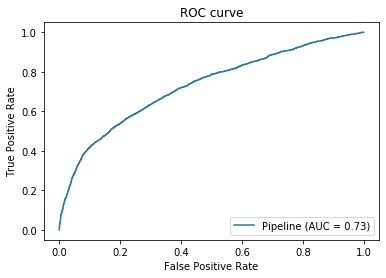

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
gbc2 = Pipeline(steps=[('preprocessor', get_preprocessor(drop=True, bucketize = True)),
                      ('classifier', GradientBoostingClassifier(random_state=seedn,n_estimators = 250,
                                                                min_weight_fraction_leaf = 0.1, 
                                                                min_samples_leaf = 12,
                                                                max_features = 0.8, 
                                                                max_depth = 9,
                                                                n_iter_no_change = 20
                                                               ))])
run_model(gbc2,X_train_up, y_train_up, X_test, y_test)

__Out of the models we tried, Gradient Boosting Classifier gives us the best test AUC score of 0.728. It is still not ideal and we continue to see boosting trees and bootstrapping trees(forest) overfit on the training data, although they perform better than the simpler linear model.__

*We could do more here but let's conclude the Sklearn models and move on to XGBoost and CatBoost too see how their off the shelf model compares to Sklearns Random Forest and Gradient Boosting Models.*